In [1]:
import pandas as pd
from plotly import offline as pyo
from plotly import graph_objects as go
import numpy as np
import os
from scipy import ndimage as ndi
from jw_utils import app_functions as afns
from jw_utils import parse_gff as pgf
from jw_utils import parse_fasta as pf
from jw_utils import genome_utils as gu
from jw_utils import parse_gbk as pgb
from jw_utils import plotly_utils as pu
from jw_utils import file_utils as fu
from jw_utils import gene_profile as gp
from Bio import SeqIO
import bisect
import processing as pr
import pysam

hello


In [42]:

path_to_gff = '/Users/jonwinkelman/Trestle_projects/Eustaquio_lab/RNAseq_dash_app/Epigenetics_Project/references/FERM_BP3421.gff'
path_to_strGTF_neg = '/Users/jonwinkelman/Trestle_projects/Eustaquio_lab/RNAseq_dash_app/Epigenetics_Project/Trestle_alignments/transcript_calling/merge_all_negStrand.gtf'
path_to_bam_mergedAlignments_neg = '/Users/jonwinkelman/Trestle_projects/Eustaquio_lab/RNAseq_dash_app/Epigenetics_Project/Trestle_alignments/transcript_calling/merge_all_negStrand.bam'

path_to_valcount_dir = './results/analysis/value_counts'
path_to_annot_file = './data/references/Reference_FERM_BP3421.gbk'
contig_names = ['BF000000.1','BF000000.2','BF000000.3','BF000000.4','BF000000.5']
path_to_fa_genomes = './data/references/concat_references.fa'

In [11]:
sam_align_obj = pysam.AlignmentFile(path_to_bam_mergedAlignments_neg, 'rb')
bf1_pilup = sam_align_obj.pileup(contig='BF000000.1')
bf2_pilup = sam_align_obj.pileup(contig='BF000000.2')
bf3_pilup = sam_align_obj.pileup(contig='BF000000.3')
bf4_pilup = sam_align_obj.pileup(contig='BF000000.4')
bf5_pilup = sam_align_obj.pileup(contig='BF000000.5')



In [40]:

def make_wig_from_pilup(bam_filepath, wig_path, contig):
    "genome position is 1-based"
    df = pd.DataFrame()
    pilup = sam_align_obj.pileup(contig=contig)
    file_lines = []
    header_line = f'variableStep chrom={contig}'
    file_lines.append(header_line)
    for col in pilup:
        line = f'{col.reference_pos+1} {col.nsegments}'
        file_lines.append(line)
    with open(wig_path, 'w') as f:
        for line in file_lines:
            f.write(line + '\n')
            
for contig in contig_names:
    wig_path = f'./Epigenetics_Project/Trestle_alignments/stringtie/{contig}_pilup_merged_minus_strand.wig'
    make_wig_from_pilup(path_to_bam_mergedAlignments_neg, wig_path, contig=contig)


### Filtering out stringtie transcripts that are more reliable, and editing them
filter for  
    -Select stringtie transcripts that start between two genes on one of the  
DNA strands  
Filter out transcripts that  
-Have low read Density  
have no sudden increase in reads over a window of nts  
Edit   
-If stringtie transcript ends in middle of gene, extend transcript to end of that gene  


In [127]:
class seq_attributes:
    'make a sequence object from a partially processed line in a stringtie GTF file'
    def __init__(self, line, anot_lst, attributes_dict, *args, **kwargs):
        self.line = line
        self.ID = attributes_dict['gene_id']
        self.transcript_id = attributes_dict.get('transcript_id')
        self.coverage = attributes_dict.get('cov')
        self.FPKM = attributes_dict.get('FPKM')
        self.TPM = attributes_dict.get('TPM')

        self.chromosome = anot_lst[0]
        self.source = anot_lst[1]
        self.feature_type = anot_lst[2]
        self.start = int(anot_lst[3])
        self.end = int(anot_lst[4])
        self.score = anot_lst[5]
        self.strand = anot_lst[6]   
        self.phase = anot_lst[7]


In [158]:


def make_GTF_seq_obj(path_to_GTF, feature_type='transcript'):
    "make a dict of seq objects from a stringtie GTF"
    
    with open(path_to_GTF, 'r') as f:
        seq_dict = {}     
        for i,line in enumerate(f):
            line = line.replace('"','')
            line = line.replace('\n','')[:-1]
            if line[0] != '#' and line[0] != ' ':
                anot_lst = line.split('\t')
                if len(anot_lst) <6:
                    raise Exception(f'line {i+1} in {path_to_gff3} does not contain all annotation fields')
                if anot_lst[2] == feature_type:
                    attributes = anot_lst[-1].replace('; ', ';')
                    if attributes.find('gene_id') !=-1:
                        temp = [key_val.split(' ') for key_val in attributes.split(';')]
                        attributes_dict = {key_val[0]:key_val[1] for key_val in temp}
                        ID = attributes_dict['gene_id']
                        seq_dict[ID] = seq_attributes(line, anot_lst, attributes_dict)
        return seq_dict
                        
stringtie_seqobj_dict_negs = make_GTF_seq_obj(path_to_strGTF_neg, feature_type='transcript')

FERM_seqobj_dict_negs={}
for gene_obj in pgf.make_seq_object_dict(path_to_gff).values():
    if gene_obj.strand == '-':
        FERM_seqobj_dict_negs[gene_obj.ID]= gene_obj

### Select stringtie transcripts that start between two genes on one of the DNA strands


In [218]:
def make_startStop_df_for_each_contig(seq_obj_dict, contig_names):
     "Return a dict of df, each containing sorted start and stop coordinates of genes"
    geneRange_dict = {contig:[] for contig in contig_names}
    df_dict = {}
    for obj in seq_obj_dict.values():
        geneRange_dict[obj.chromosome].append((obj.start, obj.end))
    for contig in contig_names:
        df_dict[contig] = pd.DataFrame(geneRange_dict[contig])
        df_dict[contig].columns = ['start', 'end']
        df_dict[contig] = df_dict[contig].sort_values('start')
    return df_dict

df_dict = make_startStop_df_for_each_contig(FERM_seqobj_dict_negs, contig_names)

In [248]:

def is_coordinate_within_gene(coordinate, contig, df_dict):
    "determine if the given gene coordinate on a contig is within a gene"

    index = bisect.bisect_right(df_dict[contig]['start'], coordinate)-1
    if index<0:
        return False
    elif coordinate <= df_dict[contig].loc[index, 'end']:
        return True
    else: return False



In [255]:
def filter_in_intergene_starts(stringtie_seqobj_dict_negs):
    pass
for gene_obj in stringtie_seqobj_dict_negs.values():
    if gene_obj.strand=='-':
        if not is_coordinate_within_gene(gene_obj.end, gene_obj.chromosome, df_dict):
            print(gene_obj.ID, gene_obj.chromosome)
    elif gene_obj.strand=='+'::
        if not is_coordinate_within_gene(gene_obj.start, gene_obj.chromosome, df_dict)
        

STRG.1 BF000000.3
STRG.2 BF000000.3
STRG.4 BF000000.3
STRG.6 BF000000.3
STRG.9 BF000000.3
STRG.10 BF000000.3
STRG.11 BF000000.3
STRG.12 BF000000.3
STRG.13 BF000000.3
STRG.14 BF000000.3
STRG.15 BF000000.3
STRG.16 BF000000.3
STRG.24 BF000000.3
STRG.26 BF000000.3
STRG.27 BF000000.3
STRG.28 BF000000.3
STRG.30 BF000000.3
STRG.31 BF000000.3
STRG.32 BF000000.3
STRG.57 BF000000.3
STRG.62 BF000000.3
STRG.63 BF000000.3
STRG.64 BF000000.3
STRG.65 BF000000.3
STRG.66 BF000000.3
STRG.71 BF000000.3
STRG.75 BF000000.3
STRG.79 BF000000.3
STRG.82 BF000000.3
STRG.83 BF000000.3
STRG.84 BF000000.3
STRG.86 BF000000.3
STRG.87 BF000000.3
STRG.88 BF000000.3
STRG.90 BF000000.3
STRG.91 BF000000.3
STRG.92 BF000000.3
STRG.93 BF000000.3
STRG.94 BF000000.3
STRG.95 BF000000.3
STRG.96 BF000000.3
STRG.97 BF000000.3
STRG.98 BF000000.3
STRG.99 BF000000.3
STRG.100 BF000000.3
STRG.101 BF000000.3
STRG.102 BF000000.3
STRG.103 BF000000.3
STRG.105 BF000000.3
STRG.106 BF000000.3
STRG.107 BF000000.3
STRG.108 BF000000.3
STRG.109 

STRG.1069 BF000000.1
STRG.1070 BF000000.1
STRG.1071 BF000000.1
STRG.1072 BF000000.1
STRG.1073 BF000000.1
STRG.1074 BF000000.1
STRG.1076 BF000000.1
STRG.1077 BF000000.1
STRG.1080 BF000000.1
STRG.1081 BF000000.1
STRG.1082 BF000000.1
STRG.1084 BF000000.1
STRG.1085 BF000000.1
STRG.1087 BF000000.1
STRG.1088 BF000000.1
STRG.1089 BF000000.1
STRG.1090 BF000000.1
STRG.1091 BF000000.1
STRG.1092 BF000000.1
STRG.1093 BF000000.1
STRG.1105 BF000000.1
STRG.1107 BF000000.1
STRG.1108 BF000000.1
STRG.1109 BF000000.1
STRG.1110 BF000000.1
STRG.1116 BF000000.1
STRG.1118 BF000000.1
STRG.1119 BF000000.1
STRG.1120 BF000000.1
STRG.1121 BF000000.1
STRG.1122 BF000000.1
STRG.1123 BF000000.1
STRG.1125 BF000000.1
STRG.1126 BF000000.1
STRG.1127 BF000000.1
STRG.1128 BF000000.1
STRG.1131 BF000000.1
STRG.1132 BF000000.1
STRG.1135 BF000000.1
STRG.1136 BF000000.1
STRG.1137 BF000000.1
STRG.1138 BF000000.1
STRG.1139 BF000000.1
STRG.1140 BF000000.1
STRG.1141 BF000000.1
STRG.1142 BF000000.1
STRG.1144 BF000000.1
STRG.1145 BF0

In [247]:
df_dict[contig]

,start,end
0,11,889
1,5963,6055
2,6997,7548
3,8794,9120


# Code below from first attempt to find Eustaquio TSS

In [11]:
sam_align_obj = pysam.AlignmentFile(path_to_bam_mergedAlignments_neg, 'rb')
bf1_pilup = sam_align_obj.pileup(contig='BF000000.1')


In [11]:
sam_align_obj = pysam.AlignmentFile(path_to_bam_mergedAlignments_neg, 'rb')
bf1_pilup = sam_align_obj.pileup(contig='BF000000.1')


## Description of initial steps
#### raw data description './data/...'
working directory: ('~/Dropbox/Trestle_projects/Eustaquio_lab/RNAseq_dash_app')
1) 5 chromosomes/plasmids: ('BF000000.1', 'BF000000.2', 'BF000000.3', 'BF000000.4', 'BF000000.5') './data/references' 
    - combined these files into one fasta ( './data/references/concat_references.fa' )
2) 12 paired end fastq files (6 R1 +  6 R2) ('../Illumina_RNA_Reads/fastq_files')
    - aligned with bowtie2 with our nextflow pipeline (see the multiqc report) using standard settings (../new_alignments/Bowtie_aligned')
    - extracted just 5' (rna) end of the paired end segment
        -5’ end of reads with flags 147 or 163 faced same direction as predicted RNAs



#### All paths to data

### Make a example of clean data and difference kernal and plot it

In [3]:
y0 = np.full(50, 0)
y1 = np.full(50, 1)
y = np.concatenate([y0,y1])
x = np.array(range(len(y)))
t = ndi.convolve(y, [1,0,-1], mode='reflect')
fig = pu.quick_line(x =x, y = t, name='convolved w diff kernal' )
data = pu.quick_line(x =x, y = y, name='clean data'  )['data'][0]
fig = fig.add_trace(data)
pyo.plot(fig)


'temp-plot.html'

### First processing steps
1) Make dataframe of summed reads at each genomic position from all experiments
2) Make transcription start site TssFinder object
3) Find all tss windows and return df dictionary with reads for each gene. 100 nt before start codon up to start codon
4) Make figure dictionary containing plotly figs for reads in the tss window and for the diff kernal-convolved reads


In [102]:
import processing as pr
df = pr.get_read_sums(path_to_valcount_dir,'BF000000.1')
tf_sums = gp.TssFinder(path_to_annot_file, val_counts_df=df, contig_name='BF000000.1')
tss_windows = tf_sums.get_region_hits(read_density_cut=0.2)
fig_dict= pr.make_fig_dict(path_to_annot_file,contig_name='BF000000.1', kernal_type='diff',plot_kernal=False, read_density_cut=0.2)

./results/analysis/value_counts/BF000000.1_BAO_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_2_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_2_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_2_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_2_filtered.txt_val_cnts.csv


In [105]:
print(gb_dict['BF000000.1']['tmp_003403'].qualifiers['product'])
f = fig_dict['tmp_003403']

['non-specific DNA-binding protein DpsA']


'temp-plot.html'

In [109]:
print(gb_dict['BF000000.1']['tmp_003403'].qualifiers['product'])
print(gb_dict['BF000000.1']['tmp_003403'].location.start)
print(gb_dict['BF000000.1']['tmp_003403'].location.end)

['non-specific DNA-binding protein DpsA']
3746411
3746900


In [ ]:
fig_dict= pr.make_fig_dict(path_to_annot_file,contig_name='BF000000.1', kernal_type='diff',plot_kernal=False, read_density_cut=0.2)
genes= list(fig_dict.keys()) 
plus_genes_tss = list(set(genes).intersection(set(tf_sums.plus_strand_genes)))  #get all genes on the +strand that have windows
gb_dict = pgb.build_genbank_dict(path_to_annot_file)



def get_tss(tss_window):
    ser = ndi.convolve(tss_window,[1,0,-1])
    df = pd.DataFrame({gene:tss_window, 'diff_kernal':ser}, index = tss_window.index)
    filt1 = df.loc[:,'diff_kernal'] > 0
    filt2 = df.loc[:,gene] > 0
    df = df.loc[filt1,:] 
    df = df.loc[filt2,:]
    d = {}
    pre = {}
    post = {}
    window_size = 20
    for position in df.index:
        ave_reads = tss_window.sum()/tss_window.shape[0]
        pre_window_reads = tss_window.loc[position-window_size:position].sum()
        post_window_reads = tss_window.loc[position:position+window_size].sum()
        if post_window_reads/window_size < ave_reads/2:
            post_window_reads=0
        #print(f'position: {position} post_window_reads: {post_window_reads}')
        if pre_window_reads==0:
            pre_window_reads=pre_window_reads+0.000000001
        #print(f'position: {position} pre_window_reads: {pre_window_reads}\n')
        d[position]=(post_window_reads-pre_window_reads)/pre_window_reads
        pre[position] = pre_window_reads
        post[position] = post_window_reads
    df_hypoth = pd.DataFrame().from_dict(d, orient='index')
    df_hypoth.columns = ['enrichment']
    df_hypoth['post'] = list(post.values())
    df_hypoth['pre'] = list(pre.values())
    return df_hypoth.sort_values('enrichment', ascending=False)

# df_dict = {}
# for gene in plus_genes_tss:
#     df_dict[gene] = get_tss(tss_windows[gene])


###pick a gene
# gene = plus_genes_tss[8]
for i in range(50):
    gene = plus_genes_tss[i]
    print(gene)
    print(gb_dict['BF000000.1'][gene].location.strand)
    print(gb_dict['BF000000.1'][gene].qualifiers['product'])
    fig = fig_dict[gene]
    df = get_tss(tss_windows[gene])
    for i,pos in enumerate(df.index):
        if i<1:
            fig.add_vline(x=pos,line_width=1, line_dash='dash')
    fig.write_html(f'./figs/{gene}_putative_tss.html')

In [45]:
a = fig_dict[gene]
#pf.get_seq_region(path_to_fa_genomes,'BF000000.1',18757,18857)


In [ ]:
name='Histogram of read density in tss window'
ser = pd.Series(dens_dict.values())
#
trace = pu.plot_bar_with_outliers(ser, name=name, end = 20)
pyo.plot(go.Figure(data=trace))

### Sandbox for developing kernal to find steps

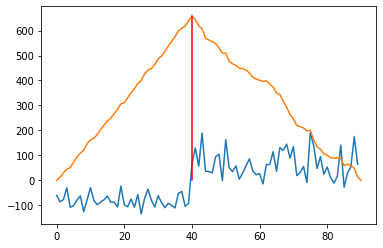

In [111]:
import numpy as np
from matplotlib import pyplot as plt


d = '''594.          568.55555556  577.22222222  624.55555556  546.66666667
552.88888889  575.55555556  592.33333333  528.88888889  576.11111111
625.          574.22222222  556.33333333  567.66666667  576.66666667
591.66666667  566.33333333  567.33333333  547.44444444  631.11111111
555.66666667  548.66666667  579.44444444  546.88888889  597.55555556
519.88888889  582.33333333  618.88888889  574.55555556  547.44444444
593.11111111  565.66666667  544.66666667  562.66666667  554.11111111
543.88888889  602.33333333  609.77777778  550.55555556  561.88888889
719.33333333  784.44444444  711.22222222  843.66666667  691.33333333
690.11111111  684.33333333  749.11111111  759.11111111  653.33333333
817.11111111  705.22222222  689.44444444  712.33333333  659.
683.88888889  713.          740.44444444  692.22222222  677.33333333
681.44444444  640.          717.55555556  717.88888889  769.22222222
690.88888889  786.          774.66666667  799.44444444  743.44444444
789.88888889  673.66666667  685.66666667  709.88888889  645.55555556
846.11111111  792.77777778  702.22222222  749.44444444  678.55555556
707.55555556  665.77777778  643.55555556  671.44444444  795.66666667
627.22222222  684.55555556  708.44444444  829.66666667  719.        '''

dary = np.array([*map(float, d.split())])

dary -= np.average(dary)

step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))

dary_step = np.convolve(dary, step, mode='valid')

# get the peak of the convolution, its index

step_indx = np.argmax(dary_step)  # yes, cleaner than np.where(dary_step == dary_step.max())[0][0]

# plots

plt.plot(dary)

plt.plot(dary_step/10)

plt.plot((step_indx, step_indx), (dary_step[step_indx]/10, 0), 'r')

array([ -60.70864198,  -86.15308642,  -77.48641976,  -30.15308642,
       -108.04197531, -101.81975309,  -79.15308642,  -62.37530865,
       -125.81975309,  -78.59753087,  -29.70864198,  -80.48641976,
        -98.37530865,  -87.04197531,  -78.04197531,  -63.04197531,
        -88.37530865,  -87.37530865, -107.26419754,  -23.59753087,
        -99.04197531, -106.04197531,  -75.26419754, -107.81975309,
        -57.15308642, -134.81975309,  -72.37530865,  -35.81975309,
        -80.15308642, -107.26419754,  -61.59753087,  -89.04197531,
       -110.04197531,  -92.04197531, -100.59753087, -110.81975309,
        -52.37530865,  -44.9308642 , -104.15308642,  -92.81975309,
         64.62469135,  129.73580246,   56.51358024,  188.95802469,
         36.62469135,   35.40246913,   29.62469135,   94.40246913,
        104.40246913,   -1.37530865,  162.40246913,   50.51358024,
         34.73580246,   57.62469135,    4.29135802,   29.18024691,
         58.29135802,   85.73580246,   37.51358024,   22.62469

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonwinkelman/Dropbox/Trestle_projects/Mukherjee_lab/csr/csrA_sequences.afa'

,R5VJ269CLOT,A0A410PSS99FIRM,A0A1R1MCT79MICC,A0A0F4SZE5PSEFL,A0A024QIU99BACI,J0WTW19CLOT,A0A5E7Q275PSEFL,A0A0P6WXF59CHLR,A0A1H2QTN99FIRM,A0A1E3A7529FIRM,...,CSRAMETCA,A0A4R3HYZ29GAMM,A0A2K8L6U29PROT,A0A0E4HEC29BACL,A0A2K8L6J79PROT,S7TEF19DELT,CSRACALBD,A0A380MWJ89GAMM,CSRASYNAS,A0A367W9B69PROT
R5VJ269CLOT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A410PSS99FIRM,0.823821,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A1R1MCT79MICC,0.847880,0.718987,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A0F4SZE5PSEFL,0.745928,0.713805,0.706452,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A024QIU99BACI,0.774704,0.669323,0.694340,0.808765,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S7TEF19DELT,0.906344,0.766026,0.763804,0.680498,0.926316,0.819620,0.635246,0.694704,0.692557,0.763240,...,0.576336,0.896667,0.742671,0.642361,0.801917,0.000000,NaN,NaN,NaN,NaN
CSRACALBD,0.845960,0.693548,0.708861,0.652318,0.629482,0.668449,0.623762,0.668407,0.645946,0.718016,...,0.640867,0.755747,0.679348,0.620787,0.697802,0.752381,0.000000,NaN,NaN,NaN
A0A380MWJ89GAMM,0.858044,0.683007,0.669811,0.569024,0.776892,0.696078,0.534653,0.627451,0.587859,0.610390,...,0.446203,0.660131,0.587859,0.562092,0.645367,0.625000,0.687097,0.000000,NaN,NaN
CSRASYNAS,0.860349,0.717277,0.667500,0.558140,0.689243,0.742021,0.504950,0.672634,0.653439,0.659847,...,0.479876,0.760563,0.673797,0.622905,0.728000,0.746914,0.703896,0.490323,0.000000,NaN
